In [1]:
from gcm import GCM
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import normaltest

import scipy.stats as stats
from scipy.stats import zscore

from IPython.display import display
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error

## Step 0: Functions

In [2]:
def scatter(df, columns):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.scatter(df[columns[0]], df[columns[1]], alpha=0.5)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_title(f"Scatter plot of {columns[0]} vs {columns[1]}")
    plt.show()

In [3]:
def compute_multipole(df: pd.DataFrame, columns: list, method="pearson"):
    corr_matrix = df[columns].corr(method=method)
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    multipole = 1 - min(eigenvalues)
    return multipole

In [4]:
def keep_normal_columns(df, alpha=0.05):
    normal_cols = []
    for col in df.columns:
        # Run normality test on the column
        stat, p = normaltest(df[col].values)
        if p > alpha:
            normal_cols.append(col)
    return df[normal_cols]


In [5]:
def plot_distributions(df, cols, ncols=3):
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, ax=axes[i], bins=40, color="steelblue")
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

    # QQ plots
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        stats.probplot(df[col], dist="norm", plot=axes[i])
        axes[i].set_title(f"QQ-plot: {col}")
    plt.tight_layout()
    plt.show()

In [6]:
def yeo_johnson_transform(df):
        
    # Yeo-Johnson handles both positive and negative values
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Fit-transform training data
    X_trans = pt.fit_transform(df)
    
    # Put back into a DataFrame
    df_train_trans = pd.DataFrame(X_trans, columns=df.columns, index=df.index)
    return df_train_trans, pt


# Step 1: Load Data

In [8]:
df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv", nrows = 10000)
numeric_df = df.select_dtypes(include="number")
numeric_df = numeric_df.dropna(axis=1).iloc[:,2:]  # Drop columns with NaNs

columns_to_drop = ['policy_code', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths','delinq_amnt', 'tax_liens','pub_rec_bankruptcies']
numeric_df = numeric_df.drop(columns=columns_to_drop)
rename_map = {
    # Scenario 1
    'mort_acc': 'number_of_mortgage_accounts', # Number of mortgage accounts.
    'tot_hi_cred_lim': 'total_credit_limit', # Total high credit/credit limit
    'total_bal_ex_mort': 'balance_excl_mortgage', # Total credit balance excluding mortgage

    # Scenario 2
    'delinq_2yrs': 'delinquencies_2yrs', # The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
    'int_rate': 'interest_rate', # Interest Rate on the loan
    # total_credit_lim
    
    # Scenario 3
    'annual_inc': 'annual_income' # The self-reported annual income provided by the borrower during registration.
    # interest_rate
    # total_credit_limit
}


numeric_df = numeric_df.rename(columns=rename_map)

df_train = numeric_df.iloc[:9000,:]
df_test = numeric_df.iloc[9000:,:]

# these are hardcoded to allow the retransform. These are columns which are normal when transformed with yeo-johnson and alpha=0.05.
norm_cols = ['open_acc', 'total_acc', 'total_rec_int', 'acc_open_past_24mths',
       'mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_sats']
df_train = df_train[norm_cols]
df_train_trans, pt = yeo_johnson_transform(df_train[norm_cols])
df_normal_trans = keep_normal_columns(df_train_trans, alpha=0.05)

print("Original number of columns:", df_train.shape[1])
print("Number of approx. normal columns:", df_normal_trans.shape[1])
print("Kept columns:", list(df_normal_trans.columns))
df_normal_trans.head()

Original number of columns: 9
Number of approx. normal columns: 9
Kept columns: ['open_acc', 'total_acc', 'total_rec_int', 'acc_open_past_24mths', 'mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_sats']


/tmp/ipykernel_34518/3450786767.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/accepted_2007_to_2018Q4.csv", nrows = 10000)


,open_acc,total_acc,total_rec_int,acc_open_past_24mths,mo_sin_rcnt_tl,num_bc_tl,num_il_tl,num_op_rev_tl,num_sats
0,-0.988087,-1.165315,-0.745846,-0.130244,-0.432510,-0.570101,-0.885087,-1.090174,-0.977865
1,1.500786,1.010839,-0.598536,-0.130244,-0.797140,1.608745,-0.175392,1.879316,1.511389
2,-1.286301,-0.581417,0.358483,0.472835,1.165517,-0.892691,-0.175392,-1.090174,-1.275857
3,0.301359,-0.688513,2.190697,-0.930880,-0.797140,0.579845,-1.229873,0.492856,0.311290
4,0.126854,0.817131,-0.322973,1.391558,-0.153910,0.390806,0.437648,-0.160329,0.136763


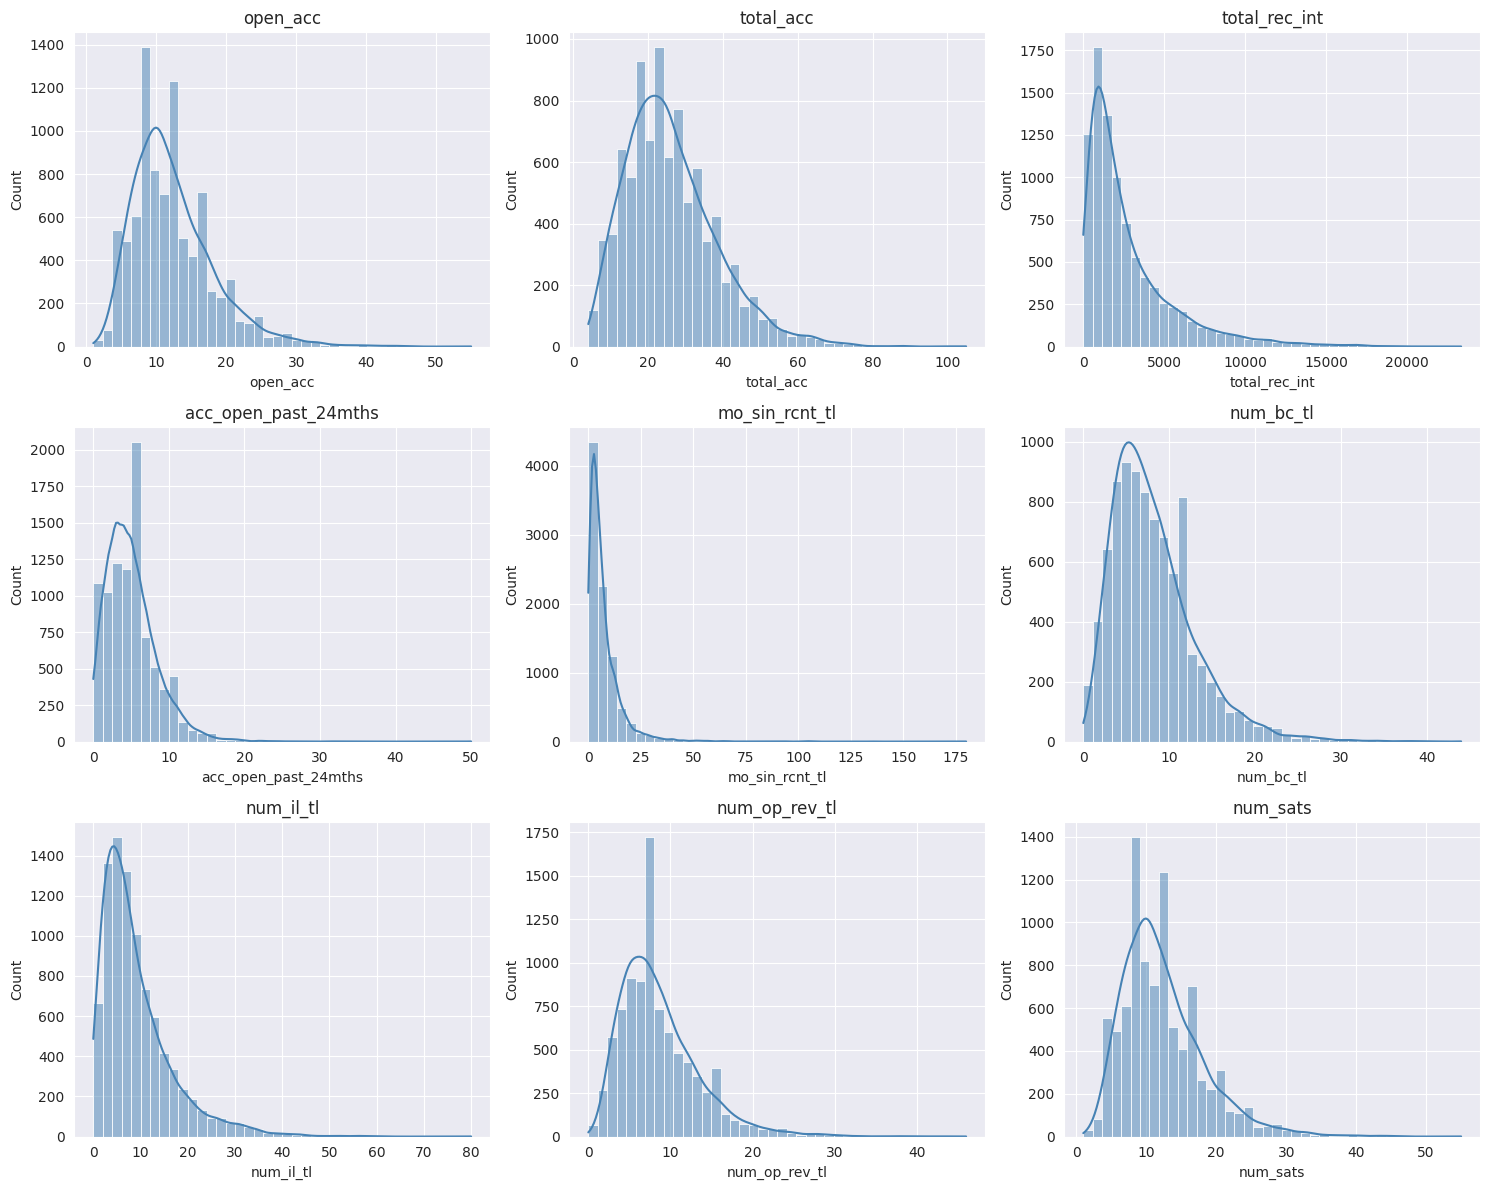

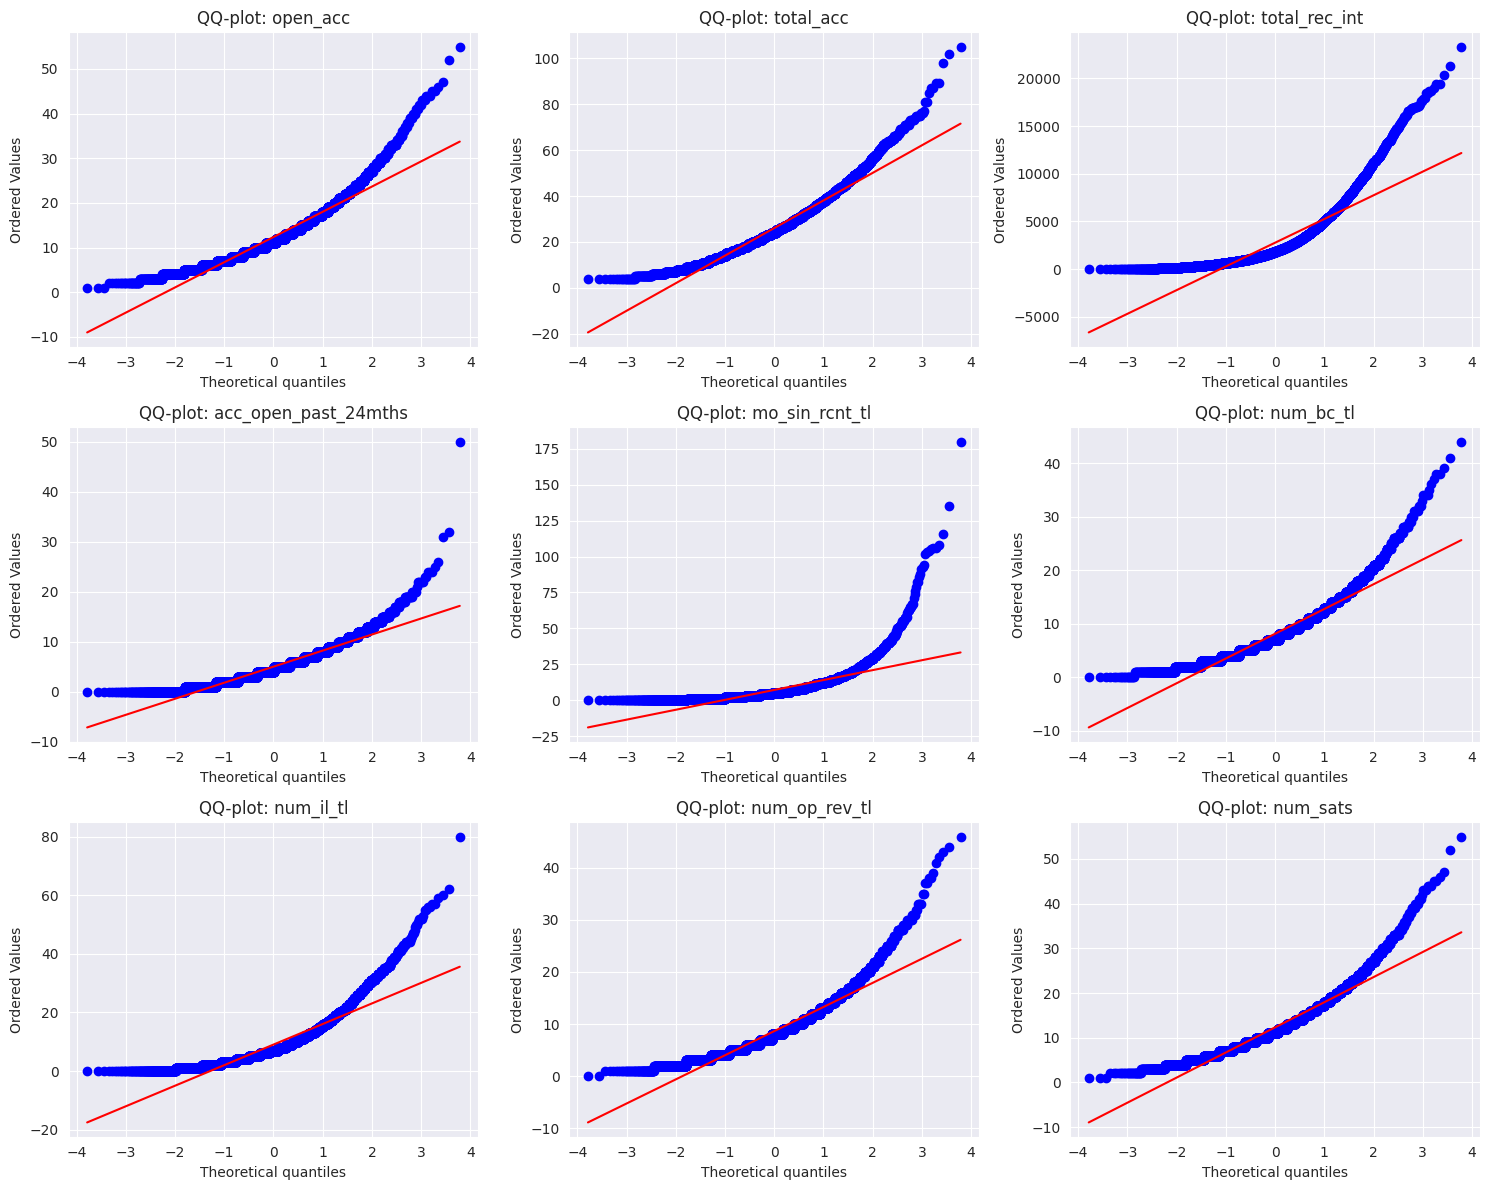

In [9]:
plot_distributions(df_train, df_train.columns)


# Step 2: Check Correlations

In [11]:
s1 = ['number_of_mortgage_accounts','total_credit_limit','balance_excl_mortgage']
s2 = ['delinquencies_2yrs','interest_rate','number_of_mortgage_accounts']
s3 = ['total_credit_limit','interest_rate', 'annual_income']

sr = ['open_acc', 'total_acc', 'total_rec_int']
sr2 = ['open_acc', 'total_acc', 'acc_open_past_24mths']
sr3 = ['mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl']

scenarios = [sr, sr2, sr3]
scenarios_dict = {i: {'columns': s, 'Original Multipole': None, 'Original transformed': None, 'Synthetic Multipole': None} for i, s in enumerate(scenarios)}

# pairwise correlations:

for i, s in enumerate(scenarios):
    corr_matrix = df_normal_trans[s].corr(method='pearson')
    print(f"Scenario {i + 1}")
    print("Pairwise correlation matrix")
    display(corr_matrix)
    multipole_val_trans = compute_multipole(df_normal_trans, s, method='pearson')
    multipole_val = compute_multipole(df_train, s, method="pearson")
    
    scenarios_dict[i]['Original Multipole'] = multipole_val
    scenarios_dict[i]['Original transformed'] = multipole_val_trans
    print(f"Columns: {s}, Multipole: {multipole_val:.4f}")
    print(f"Columns: {s}, Multipole transformed: {multipole_val_trans:.4f}")
    
    
    print("\n")

Scenario 1
Pairwise correlation matrix


,open_acc,total_acc,total_rec_int
open_acc,1.000000,0.729705,0.135747
total_acc,0.729705,1.000000,0.096447
total_rec_int,0.135747,0.096447,1.000000


Columns: ['open_acc', 'total_acc', 'total_rec_int'], Multipole: 0.7210
Columns: ['open_acc', 'total_acc', 'total_rec_int'], Multipole transformed: 0.7308


Scenario 2
Pairwise correlation matrix


,open_acc,total_acc,acc_open_past_24mths
open_acc,1.000000,0.729705,0.488790
total_acc,0.729705,1.000000,0.433641
acc_open_past_24mths,0.488790,0.433641,1.000000


Columns: ['open_acc', 'total_acc', 'acc_open_past_24mths'], Multipole: 0.7225
Columns: ['open_acc', 'total_acc', 'acc_open_past_24mths'], Multipole transformed: 0.7331


Scenario 3
Pairwise correlation matrix


,mo_sin_rcnt_tl,num_bc_tl,num_il_tl
mo_sin_rcnt_tl,1.000000,-0.153572,-0.137631
num_bc_tl,-0.153572,1.000000,0.038277
num_il_tl,-0.137631,0.038277,1.000000


Columns: ['mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl'], Multipole: 0.1797
Columns: ['mo_sin_rcnt_tl', 'num_bc_tl', 'num_il_tl'], Multipole transformed: 0.1881


# Step 3: Fit GCM and Generate Synthetic Data

In [12]:
# 1. Initialize the GCM model and fit it to your source data
gcm = GCM()
gcm.fit(df_normal_trans)

# # 2. Generate synthetic samples
synthetic_data = pd.DataFrame(gcm.sample(num_samples=50000), columns=df_normal_trans.columns)

# 3. Verify that the correlation structure is preserved
corr_real = np.corrcoef(df_train, rowvar=False)
corr_real_trans = np.corrcoef(df_normal_trans, rowvar=False)
corr_znorm = np.corrcoef(zscore(df_normal_trans), rowvar=False)
corr_synth = np.corrcoef(synthetic_data, rowvar=False)

synthetic_data.head()

,open_acc,total_acc,total_rec_int,acc_open_past_24mths,mo_sin_rcnt_tl,num_bc_tl,num_il_tl,num_op_rev_tl,num_sats
0,0.877629,0.548224,1.204431,0.545996,-0.884801,1.604288,0.920777,1.010007,0.827253
1,-0.314071,-0.121411,-0.176366,-0.156517,-0.262004,0.807574,-0.902671,-0.773866,-0.330221
2,-0.092486,-0.906296,-2.262421,-0.697267,-0.313337,-0.368119,-0.775314,-0.146767,-0.161209
3,0.374390,0.718152,-1.607270,-0.726584,0.131842,0.755788,0.406570,0.788418,0.393151
4,0.003057,1.126315,-0.419959,-0.292379,-0.241405,0.383649,0.675853,-0.040847,0.015442


In [13]:
# Compute mean and std from normally distributed original training data
means = df_normal_trans.mean()
stds = df_normal_trans.std()

# Rescale synthetic data
synthetic_rescaled = synthetic_data * stds + means

# Keep as DataFrame with same columns
synthetic_rescaled = pd.DataFrame(synthetic_rescaled, columns=df_normal_trans.columns)
corr_synth_rescaled = np.corrcoef(synthetic_rescaled, rowvar=False)

synth_inv_trans = pd.DataFrame(pt.inverse_transform(synthetic_rescaled), columns =  df_normal_trans.columns)
corr_synth_inv_trans = np.corrcoef(synth_inv_trans, rowvar=False)


# Step 4: Validate Results

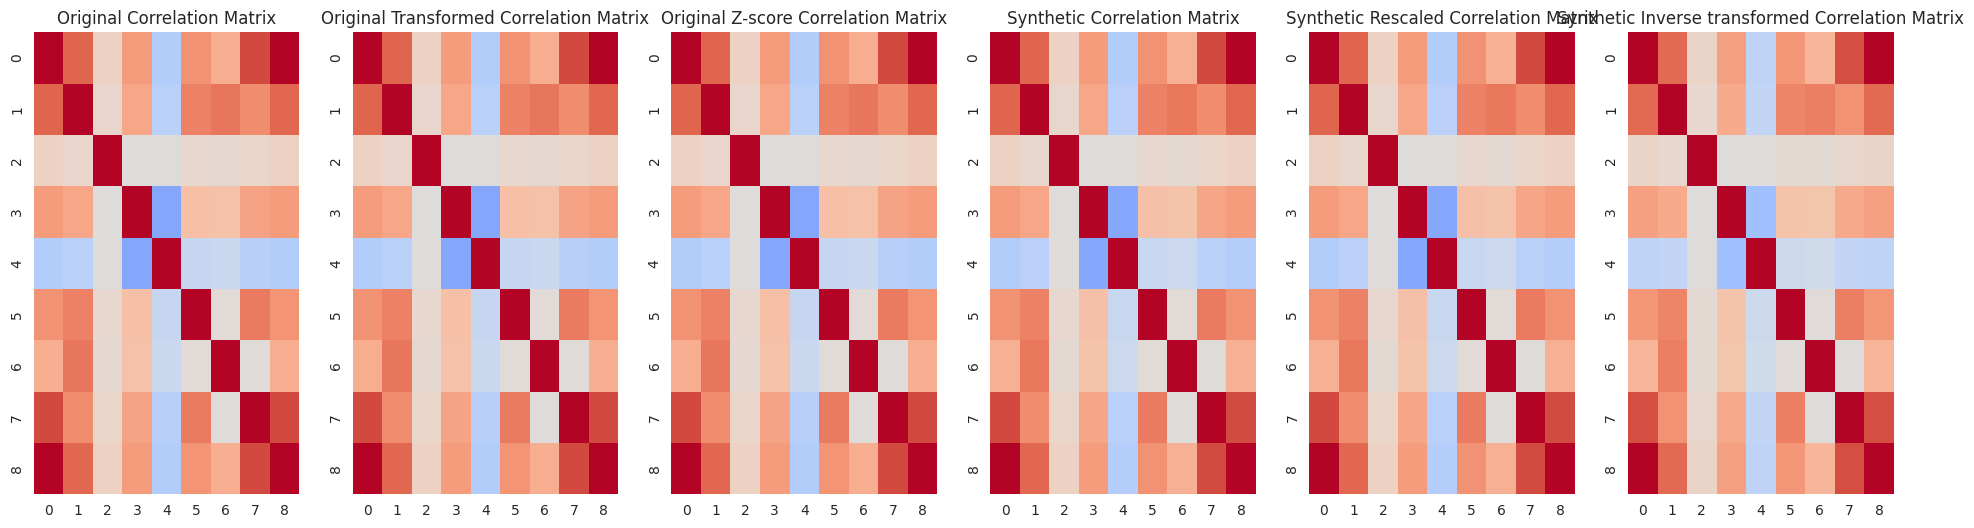

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 6, figsize=(24,6))

sns.heatmap(corr_real, ax=axes[0], cmap="coolwarm", center=0, cbar=False)
axes[0].set_title("Original Correlation Matrix")
sns.heatmap(corr_real, ax=axes[1], cmap="coolwarm", center=0, cbar=False)
axes[1].set_title("Original Transformed Correlation Matrix")

sns.heatmap(corr_znorm, ax=axes[2], cmap="coolwarm", center=0, cbar=False)
axes[2].set_title("Original Z-score Correlation Matrix")

sns.heatmap(corr_synth, ax=axes[3], cmap="coolwarm", center=0, cbar=False)
axes[3].set_title("Synthetic Correlation Matrix")
sns.heatmap(corr_synth_rescaled, ax=axes[4], cmap="coolwarm", center=0, cbar=False)
axes[4].set_title("Synthetic Rescaled Correlation Matrix")
sns.heatmap(corr_synth_inv_trans, ax=axes[5], cmap="coolwarm", center=0, cbar=False)
axes[5].set_title("Synthetic Inverse transformed Correlation Matrix")
plt.show()


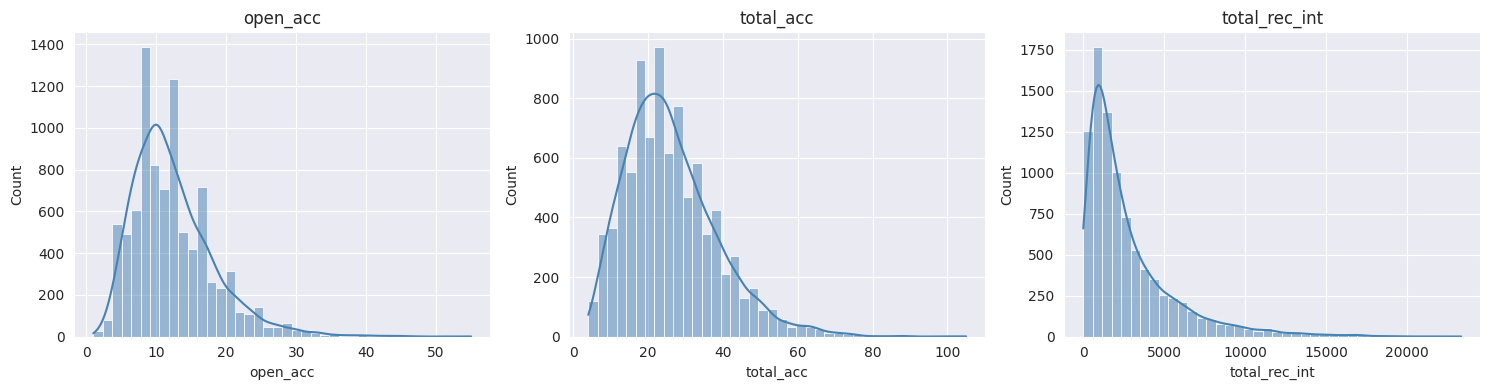

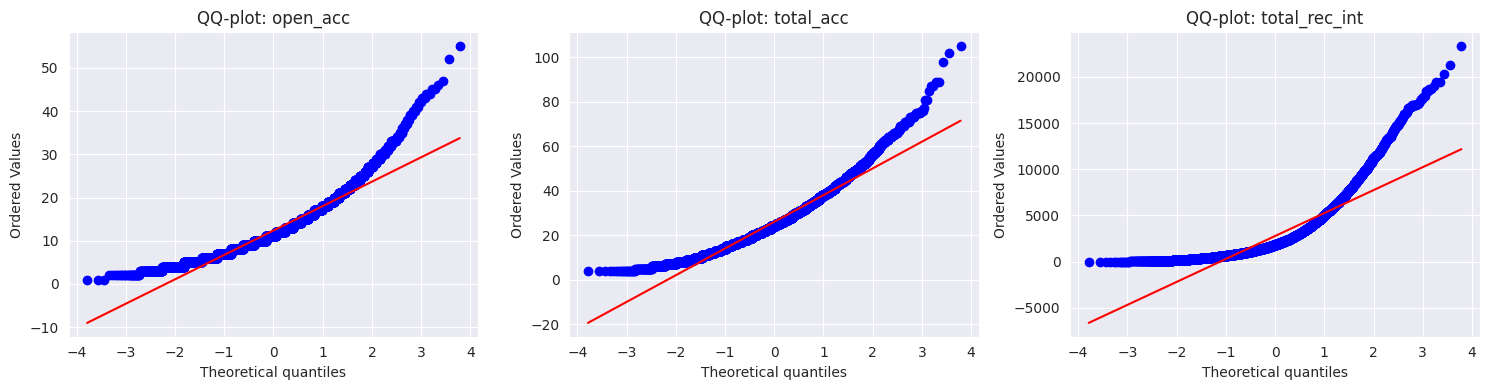

In [15]:
plot_distributions(df_train, synthetic_data.columns[:3])

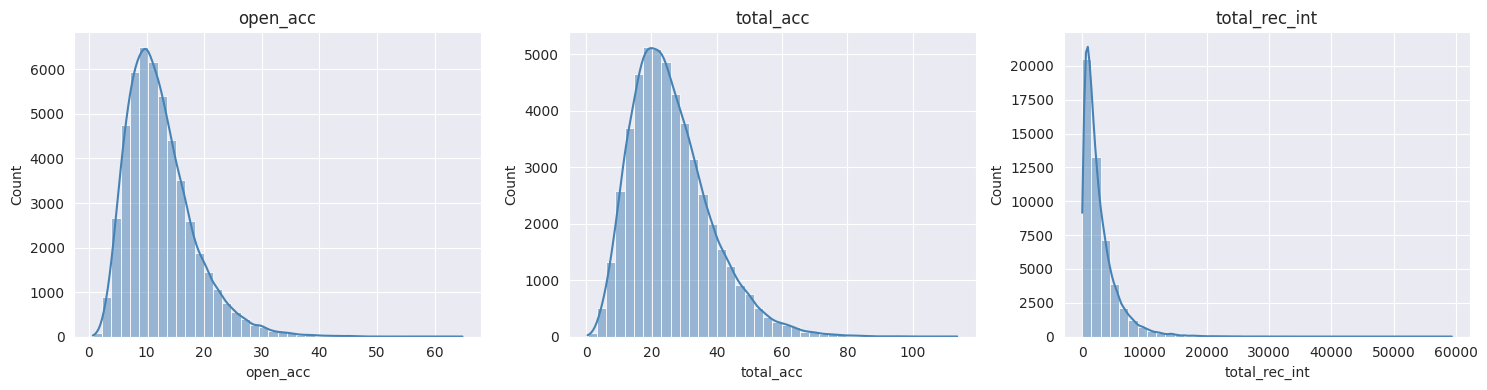

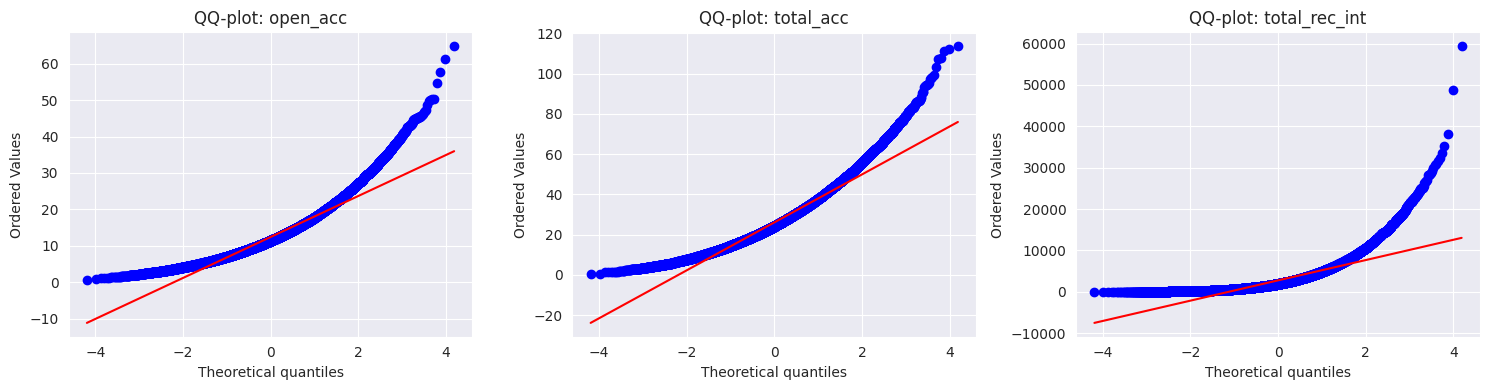

In [16]:
plot_distributions(synth_inv_trans, df_train.columns[:3])

In [17]:
# Are the multipoles preserved?
for i, s in enumerate(scenarios):
    scenarios_dict[i]['Synthetic Multipole'] = compute_multipole(pd.DataFrame(synthetic_data, columns=df_normal_trans.columns), s, method="pearson")
    scenarios_dict[i]['Synthetic Rescaled Multipole'] = compute_multipole(pd.DataFrame(synthetic_rescaled, columns=df_normal_trans.columns), s, method="pearson")
    scenarios_dict[i]['Synthetic InvTrans Multipole'] = compute_multipole(pd.DataFrame(synth_inv_trans, columns=df_normal_trans.columns), s, method="pearson")
    
    
# Convert to DataFrame
results = pd.DataFrame.from_dict(scenarios_dict, orient='index')

# Format numeric columns nicely
numeric_cols = ['Original Multipole','Original transformed', 'Synthetic Multipole', 'Synthetic Rescaled Multipole', 'Synthetic InvTrans Multipole']
results[numeric_cols] = results[numeric_cols].applymap(lambda x: f"{x:.4f}" if x is not None else "-")
display(results)


,columns,Original Multipole,Original transformed,Synthetic Multipole,Synthetic Rescaled Multipole,Synthetic InvTrans Multipole
0,"[open_acc, total_acc, total_rec_int]",0.7210,0.7308,0.7256,0.7256,0.7117
1,"[open_acc, total_acc, acc_open_past_24mths]",0.7225,0.7331,0.7284,0.7284,0.7141
2,"[mo_sin_rcnt_tl, num_bc_tl, num_il_tl]",0.1797,0.1881,0.1811,0.1811,0.1364


### Correlations are almost preserved. Definitely up until the scaled synthetic data that is still normally distributed. After detransforming it to the original distribution, the multivariate correlations are close, but significantly off.

# Step 5: Downstream task analysis


=== Correlation Matrix Similarity ===
Frobenius norm diff: 0.0379
Correlation of upper triangles: 0.9998

=== PCA Comparison ===
Explained variance ratio (first 5 comps):
  PC1: real=0.905, synth=0.235
  PC2: real=0.095, synth=0.224
  PC3: real=0.000, synth=0.131
  PC4: real=0.000, synth=0.116
  PC5: real=0.000, synth=0.105
Principal angles (radians): [0. 0. 0. 0. 0.]

=== Feature Clustering ===
              Feature  Cluster_real  Cluster_synth
0       annual_income             2              2
1  delinquencies_2yrs             6              6
2                 dti             4              4
3      fico_range_low             5              5
4     fico_range_high             5              5
5      inq_last_6mths             7              7
6            open_acc             1              1
7           revol_bal             3              3
8           total_acc             1              1


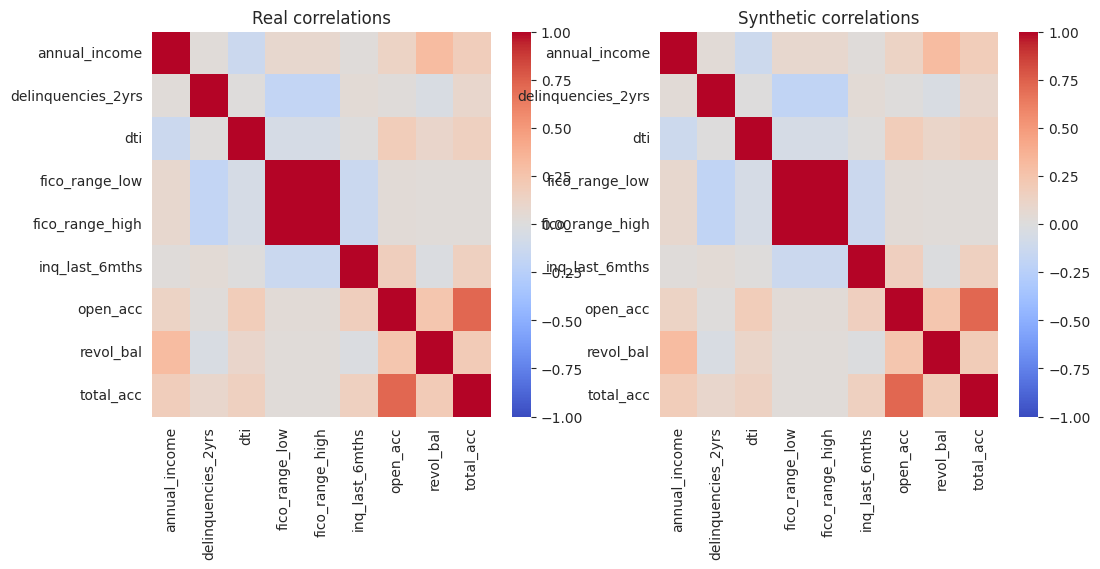

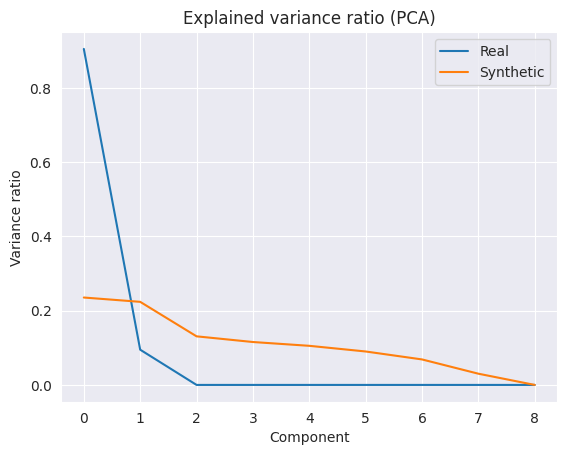

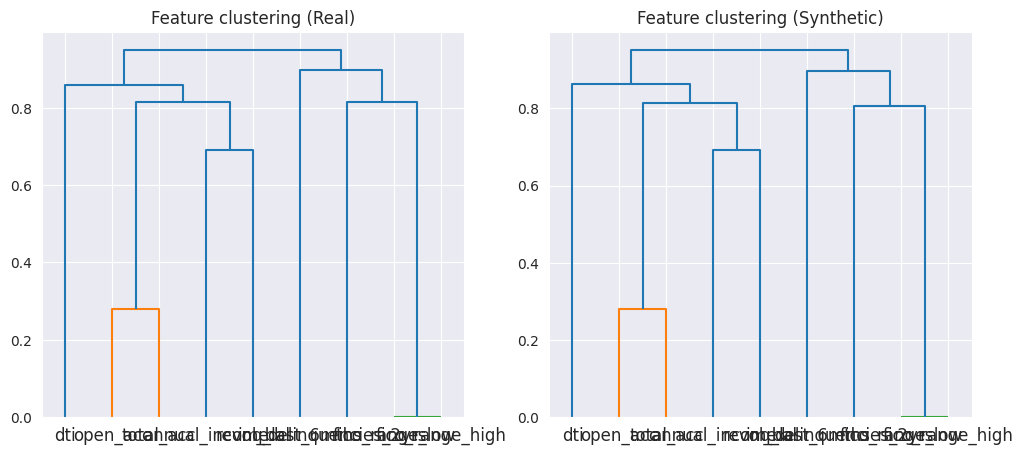

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from numpy.linalg import svd, norm

# -----------------------------
# CONFIG: select numeric features
# -----------------------------
features = [
    'annual_income', 'delinquencies_2yrs', 'dti', 'fico_range_low',
    'fico_range_high', 'inq_last_6mths', 'open_acc', 'revol_bal',
    'total_acc', 'avg_cur_bal'
]

X_real = df_train[features].dropna()
X_synth = synthetic_data[features].dropna()

# -----------------------------
# 1. Correlation matrix similarity
# -----------------------------
corr_real = X_real.corr()
corr_synth = X_synth.corr()

# Frobenius norm of difference
fro_diff = norm(corr_real.values - corr_synth.values, ord='fro')
# correlation of upper triangles
tri_real = corr_real.where(np.triu(np.ones(corr_real.shape), k=1).astype(bool)).stack()
tri_synth = corr_synth.where(np.triu(np.ones(corr_synth.shape), k=1).astype(bool)).stack()
tri_corr = np.corrcoef(tri_real, tri_synth)[0, 1]

# -----------------------------
# 2. PCA comparison
# -----------------------------
pca_r = PCA().fit(X_real)
pca_s = PCA().fit(X_synth)

# Explained variance
explained_real = pca_r.explained_variance_ratio_
explained_synth = pca_s.explained_variance_ratio_

# Principal angles between subspaces (via SVD of UᵀV)
U = pca_r.components_.T
V = pca_s.components_.T
M = U.T.dot(V)
svals = svd(M, compute_uv=False)
angles = np.arccos(np.clip(svals, -1, 1))

# -----------------------------
# 3. Feature clustering (hierarchical on correlations)
# -----------------------------
def feature_clusters(corr, threshold=0.7):
    # distance = 1 - |corr|
    dist = 1 - np.abs(corr)
    linkage_mat = linkage(squareform(dist, checks=False), method='average')
    clusters = fcluster(linkage_mat, t=1-threshold, criterion='distance')
    return clusters, linkage_mat

clusters_real, link_real = feature_clusters(corr_real)
clusters_synth, link_synth = feature_clusters(corr_synth)

# Put into dataframe
cluster_df = pd.DataFrame({
    "Feature": features,
    "Cluster_real": clusters_real,
    "Cluster_synth": clusters_synth
})

# -----------------------------
# Summary output
# -----------------------------
print("\n=== Correlation Matrix Similarity ===")
print(f"Frobenius norm diff: {fro_diff:.4f}")
print(f"Correlation of upper triangles: {tri_corr:.4f}")

print("\n=== PCA Comparison ===")
print("Explained variance ratio (first 5 comps):")
for i in range(5):
    print(f"  PC{i+1}: real={explained_real[i]:.3f}, synth={explained_synth[i]:.3f}")
print("Principal angles (radians):", np.round(angles[:5], 3))

print("\n=== Feature Clustering ===")
print(cluster_df)

# -----------------------------
# Visualizations
# -----------------------------
# Heatmaps
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(corr_real, vmin=-1, vmax=1, cmap="coolwarm", center=0, annot=False)
plt.title("Real correlations")
plt.subplot(1,2,2)
sns.heatmap(corr_synth, vmin=-1, vmax=1, cmap="coolwarm", center=0, annot=False)
plt.title("Synthetic correlations")
plt.show()

# PCA explained variance
plt.plot(explained_real, label="Real")
plt.plot(explained_synth, label="Synthetic")
plt.title("Explained variance ratio (PCA)")
plt.xlabel("Component")
plt.ylabel("Variance ratio")
plt.legend()
plt.show()

# Dendrograms
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
dendrogram(link_real, labels=features)
plt.title("Feature clustering (Real)")
plt.subplot(1,2,2)
dendrogram(link_synth, labels=features)
plt.title("Feature clustering (Synthetic)")
plt.show()


In [ ]:
# voorbeeldgebruik van de data.
# applicaties
- privacy
 # synth row, check of hij in de originele zit of niet
 # linear regressie: fico predicted door inkomen oid, is het beter met synth data (meer data) dan met de 5000 originele rijen
 # zelfde voor 'data hungry' model als random forest, xgboost, nn
 # originele split in train en test. Generatie alleen op de train. Error op de test.
 